## COMP5328 - Advanced Machine Learning
## Assignment 2: Title
----------------------------------------------------------------------------------------

## 1. Setup

### 1.1 Library Imports

In [172]:
# Common imports
import os
import glob
import numpy as np
import json
import time
import pandas as pd
from datetime import datetime
import tabulate
import random
import re

# Ploting
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import torch.optim as optim
import random
import scipy.stats as st

### 1.2 Notebook Setup

In [173]:
# Torch device setup - to use gpu if available else cpu
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Apple MPS:", device)
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("NVIDIA CUDA:", device)
else:
    device = torch.device("cpu")
    print("No GPU available, Using CPU:", device)

NVIDIA CUDA: cuda


### 1.3 Checking data folder has data files

In [174]:
# The structure of data folder.
!ls -l data

'ls' is not recognized as an internal or external command,
operable program or batch file.


### 1.4 Common variable and function setup

In [175]:
# Experiment variables
# Common
num_classes=3
dataset_folder = 'data/'

cifar_dataset = dataset_folder+'CIFAR.npz'
MNISTO3_dataset = dataset_folder+'FashionMNIST0.3.npz'
MNISTO6_dataset = dataset_folder+'FashionMNIST0.6.npz'


DATA_PATHS = {
    'fashion03': MNISTO3_dataset,
    'fashion06': MNISTO6_dataset,
    'cifar':     cifar_dataset
}

losses = ['forward','gce', 'forwardGCE', 't-revision']
losses = ['forward', 'forwardGCE', 't-revision']
# datasets = [ "fashion03", "fashion06", "cifar"]
datasets = [ "fashion03",]
base = {
    "runs":10,
    "epochs": 15,
    "batch_size":512,
    "q":0.6,
    "est_epochs":25,
    "beta":5e-4,
    "lr": 1e-4,
    "device":str(device)
}

known_T_fashion_03 = np.array(  [[0.7,0.3,0.0],
                                [0.0,0.7,0.3],
                                [0.3,0.0,0.7]], dtype=np.float32)

known_T_fashion_06 = np.array(  [[0.4,0.3,0.3],
                                [0.3,0.4,0.3],
                                [0.3,0.3,0.4]], dtype=np.float32)



In [176]:
# Define config
now = datetime.now()
now = now.strftime("%Y-%m-%d-%H_%M")
folder = "results_"+now

if os.path.exists(folder) and os.path.isdir(folder):
    os.rmdir(folder)
    os.mkdir(folder)
else:
    os.mkdir(folder)

# create each cfg
estimate = ['anchor', 'None']
qs = [0.6]
configs = []
for q in qs:
    for i, ds in enumerate(datasets):
        if ds == 'cifar':
            is_cifar = True
        else:
            is_cifar = False
        
        for loss in losses:
            for t in estimate:
                cfg = {**base, "dataset": ds, "loss":loss, "estimate_T":t, "q":q, "is_cifar":is_cifar}
                if t=='None' and ds=='cifar':
                    print(f"Skipping dataset without Known Transition Matrix: {ds}")
                else:
                    print(f"dataset: {ds}, estimate_T:{t}, loss:{loss}, q:{q}")
                    configs.append(cfg)

dataset: fashion03, estimate_T:anchor, loss:forward, q:0.6
dataset: fashion03, estimate_T:None, loss:forward, q:0.6
dataset: fashion03, estimate_T:anchor, loss:forwardGCE, q:0.6
dataset: fashion03, estimate_T:None, loss:forwardGCE, q:0.6
dataset: fashion03, estimate_T:anchor, loss:t-revision, q:0.6
dataset: fashion03, estimate_T:None, loss:t-revision, q:0.6


In [ ]:
# Common Functions
def load_npz(path):
    d = np.load(path)
    Xtr, Str = d['Xtr'], d['Str']
    Xts, Yts = d['Xts'], d['Yts']
    return Xtr, Str, Xts, Yts

def pick_known_T(tag):
    if tag == 'fashion03':
        return known_T_fashion_03
    elif tag == 'fashion06':
        return known_T_fashion_06
    else:
        return None

def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    # Cuda specific seeds
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

       
def stabilize_T(T, alpha=0.7):
    """
    Blend estimated T with identity to avoid near-singular/over-uniform matrices.
    Keeps rows summing to 1.
    """
    C = T.size(0)
    I = torch.eye(C, device=T.device, dtype=T.dtype)
    T = alpha * T + (1 - alpha) * I
    T = torch.clamp(T, 1e-3, 0.999)
    T = T / T.sum(dim=1, keepdim=True)
    return T

def plot_run_performance(all_acc, all_mean_loss, cfg, folder):
    runs = np.arange(1, len(all_acc) + 1)
    display_title = f"{cfg['dataset'].upper()} — loss:{cfg['loss']} — t_esimation:{cfg['estimate_T']} — q:{cfg['q']} Performance Across Runs"
    file_name = f"{cfg['dataset'].upper()}—loss={cfg['loss']}—t_esimation={cfg['estimate_T']}—q={cfg['q']}-Performance_Across_Runs"
    fig, ax1 = plt.subplots(figsize=(8,5))
    ax2 = ax1.twinx()
    # Accuracy (left axis)
    ax1.plot(runs, np.array(all_acc)*100, 'o-', color='tab:blue', label='Test Accuracy (%)')
    ax1.set_xlabel('Run')
    ax1.set_ylabel('Accuracy (%)', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_ylim(max((min(all_acc)*100)-10, 0), 100)

    # Loss (right axis)
    ax2.plot(runs, all_mean_loss, 's--', color='tab:red', label='Mean Train Loss')
    ax2.set_ylabel('Loss', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    plt.title(display_title)
    # fig.tight_layout()

    # the previous way
    # lines, labels = ax1.get_legend_handles_labels()
    # lines2, labels2 = ax2.get_legend_handles_labels()
    # ax1.legend(lines + lines2, labels + labels2, loc='best')

    # New way, moving legend to the bottom
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    fig.legend(lines + lines2, labels + labels2,
            loc='upper center', bbox_to_anchor=(0.5, -0.05),
            ncol=2, frameon=False)

    fig.tight_layout()
    plt.subplots_adjust(bottom=0.12) 

    # Ensures img folder exists before saving
    os.makedirs(os.path.join(folder, "img"), exist_ok=True)
    save_path = os.path.join(folder, "img", f"{file_name}.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Saved plot to: {save_path}")

    plt.show()
    



## 1. Load Dataset

### 1.0 Data Folder

In [178]:
class NpzDataset(Dataset):
    def __init__(self, X, y, is_cifar=False):
        self.X = X.astype(np.float32)
        self.y = y.astype(np.int64)
        self.is_cifar = is_cifar

        # Normalize to [0,1]
        self.X = self.X / 255.0 if self.X.max() > 1.0 else self.X

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        x = self.X[idx]
        if x.ndim == 1:
            # flat; try to infer shape 28x28 or 32x32x3
            if x.size == 28*28:
                x = x.reshape(1, 28, 28)
            elif x.size == 32*32*3:
                x = x.reshape(3, 32, 32)
            else:
                raise ValueError("Unknown flat image shape: {}".format(x.shape))
        else:
            # (H,W) or (H,W,C)
            if x.ndim == 2:
                x = x[None, ...]  # to (1,H,W)
            elif x.ndim == 3:
                # assume HWC -> CHW
                x = np.transpose(x, (2, 0, 1))
            else:
                raise ValueError(f"Unexpected image dims: {x.shape}")
        return torch.from_numpy(x), torch.tensor(self.y[idx])


def make_loaders(Xtr, Str, batch_size=128, seed=0, test_size=0.2):
    # 80/20 split each repetition
    X_tr, X_val, y_tr, y_val = train_test_split(
        Xtr, Str, test_size=test_size, random_state=seed, stratify=Str
    )

    is_cifar = (X_tr.shape[-1] == 3) if X_tr.ndim == 4 else (X_tr.shape[-1] == 32*32*3)

    train_ds = NpzDataset(X_tr, y_tr, is_cifar)
    val_ds   = NpzDataset(X_val, y_val, is_cifar)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=0)

    return train_loader, val_loader, is_cifar

def make_test_loader(Xts, Yts, batch_size=256):
    is_cifar = (Xts.shape[-1] == 3) if Xts.ndim == 4 else (Xts.shape[-1] == 32*32*3)
    test_ds = NpzDataset(Xts, Yts, is_cifar)
    return DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0)

In [179]:
class ForwardCorrectedCE(nn.Module):
    """
    Forward loss correction: minimizes CE between T^T p and noisy labels.
    T: class-transition matrix where T[i,j] = P(S=j | Y=i). Shape [C,C].
    """
    def __init__(self, T):
        super().__init__()
        self.register_buffer('T', T)  # [C,C]

    def forward(self, logits, y_noisy):
        # logits -> p(y|x)
        p = F.softmax(logits, dim=1)  # [B,C]
        # mix via T^T
        mixed = torch.clamp(p @ self.T, 1e-6, 1.0)
        log_mixed = torch.log(mixed)
        return F.nll_loss(log_mixed, y_noisy) 
    
class TRevisionLoss(nn.Module):
    """
    Joint T-revision loss: learns transition matrix T along with model weights.
    Combines forward correction with a regularization toward identity (or prior).
    """
    def __init__(self, device, C=3, q=0.7, lambda_reg=1e-1, T0=None):
        super().__init__()
        self.q = q
        self.lambda_reg = lambda_reg
        eps = 1e-6
        # ------------------------------
        # Initialize T0
        # ------------------------------
        if T0 is None:
            # Start from identity (clean labels)
            T0 = torch.eye(C, device=device, dtype=torch.float32)
        else:
            # Safely handle both numpy arrays and tensors
            T0 = torch.as_tensor(T0, dtype=torch.float32, device=device)
            # Ensure it's detached and cloned to avoid warnings
            T0 = T0.detach().clone()

        # Clamp to ensure positivity and numerical stability
        T0 = torch.clamp(T0, eps, 1.0)

        # ------------------------------
        # Logits parameterization
        # ------------------------------
        # Learn unnormalized log-values; softmax over columns later gives valid T
        self.logits = nn.Parameter(torch.log(T0))



    def forward(self, logits, y):
        """
        logits: model outputs (B, C)
        y: noisy labels (B,)
        """
        C = logits.size(1)
        T = torch.softmax(self.logits, dim=1)  # ensure column-stochastic
        p = F.softmax(logits, dim=1)
        p_noisy = torch.clamp(p @ T, 1e-6, 1.0)
        p_s = p_noisy.gather(1, y.view(-1, 1)).clamp(1e-6, 1.0)

        if self.q == 1.0:
            loss = -torch.log(p_s)
        else:
            loss = (1 - p_s.pow(self.q)) / self.q
        loss = loss.mean()

        # regularize T toward identity or prior
        T_prior = torch.eye(C, device=T.device)
        reg = self.lambda_reg * torch.norm(T - T_prior, p='fro')
        return loss + reg

class ForwardCorrectedGCE(nn.Module):
    def __init__(self, T, q):
        super().__init__()
        self.register_buffer('T', T)
        self.q = q
    def forward(self, logits, y_noisy):
        p_noisy = torch.clamp(F.softmax(logits,1) @ self.T, 1e-6, 1.0)
        p_s = p_noisy.gather(1, y_noisy.view(-1,1)).clamp(1e-6,1.0)
        return (-(p_s.log()) if self.q==1.0 else (1 - p_s**self.q)/self.q).mean()
    
class GeneralizedCrossEntropy(nn.Module):
    """
    GCE loss: L_q(p, y) = (1 - p_y^q) / q, with q in (0,1].
    q→1 recovers CE; smaller q is more robust to label noise.
    """
    def __init__(self, q):
        super().__init__()
        assert 0 < q <= 1
        self.q = q

    def forward(self, logits, y):
        p = F.softmax(logits, dim=1)
        p_y = p.gather(1, y.view(-1,1)).clamp(min=1e-6, max=1.0)
        if self.q == 1.0:
            return -torch.log(p_y).mean()
        return ((1 - p_y.pow(self.q)) / self.q).mean()

In [180]:
def conv_block(cin, cout):
    return nn.Sequential(
        nn.Conv2d(cin, cout, 3, padding=1),
        nn.BatchNorm2d(cout),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2)
    )

class SmallCNN28(nn.Module):
    """For 1×28×28 images."""
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            conv_block(1, 32),  # 14x14
            conv_block(32, 64), # 7x7
            nn.Flatten(),
            nn.Linear(64*7*7, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 3)
        )
    def forward(self, x):
        return self.net(x)


class SmallCNNCifar(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            conv_block(3, 64),     # 16x16
            conv_block(64, 128),   # 8x8
            conv_block(128, 256),  # 4x4
            conv_block(256, 512),  # 2x2
            nn.Dropout(0.3)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512*2*2, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, 3)
        )
    def forward(self, x):
        return self.classifier(self.features(x))


def make_model(is_cifar, device=None):
    model = SmallCNNCifar() if is_cifar else SmallCNN28()
    if device is not None:
        model = model.to(device)
    return model

In [181]:
@torch.no_grad()
def accuracy(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        pred = logits.argmax(dim=1)
        correct += (pred == yb).sum().item()
        total += yb.numel()
    return correct / max(total, 1)


def fit_model(model, train_loader, val_loader, device, loss_name, T, q, beta=0.2, epochs=10, lr=1e-3):

    model.to(device)

    if loss_name == 'forward':
        assert T is not None, "Forward correction requires known/estimated T"
        criterion = ForwardCorrectedCE(T)
    elif loss_name == 'forwardGCE':
        assert T is not None, "Forward correction requires known/estimated T"
        criterion = ForwardCorrectedGCE(T, q=q)
    elif loss_name == 't-revision':
        assert T is not None, "T-revision requires known/estimated T"
        criterion = TRevisionLoss(C=3,device=device, q=q, lambda_reg=beta, T0=T).to(device)
    else:
        criterion = GeneralizedCrossEntropy(q=q)
        
    criterion = criterion.to(device)

    if isinstance(criterion, TRevisionLoss):
       optimizer = optim.Adam([
            {'params': model.parameters(), 'lr': lr},
            {'params': criterion.parameters(), 'lr': lr * 20}
        ], weight_decay=1e-4)
    else:
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=2, min_lr=1e-5
    )

    # ---- Optional warm-up on clean CE loss ----
    if loss_name in ['forwardGCE', 't-revision']:
        warmup_epochs = 3
        warmup_criterion = nn.CrossEntropyLoss()
        print(f"-----------Warm-up training for {warmup_epochs} epochs with CE loss-----------")
        warmup_optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
        for w in range(warmup_epochs):
            train_one_epoch(model, train_loader, warmup_optimizer, warmup_criterion, device)
        print("-----------Warm-up for {warmup_epochs} epochs with CE loss finished.-----------\n")

    best_val = -np.inf
    best_state = None
    loss_arr = [] 
    grad_norms = []
    val_acc_arr = []

    for epoch in range(epochs):
        mean_loss, mean_acc, _ = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_acc = accuracy(model, val_loader, device)
        val_acc_arr.append(val_acc)
        # --- Gradient norm tracking ---
        total_norm = 0.0
        for p in model.parameters():
            if p.grad is not None:
                total_norm += p.grad.data.norm(2).item()
        grad_norms.append(total_norm)

        # --- Scheduler step ---
        old_lr = optimizer.param_groups[0]['lr']
        if epoch > 5:
            scheduler.step(val_acc)
        new_lr = optimizer.param_groups[0]['lr']
        if new_lr < old_lr:
            print(f"-----------LR reduced from {old_lr:.6f} → {new_lr:.6f}-----------")

        # --- Best model checkpoint ---
        if val_acc > best_val:
            best_val = val_acc
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        if epoch==0 or epoch == (epochs-1):
            print(f"Epoch {epoch+1}/{epochs} |: val_acc={val_acc*100:.2f}%, best_val={best_val*100:.2f}%, mean_loss={mean_loss:.4f}, mean_acc={mean_acc*100:.2f}%, grad_norm: {total_norm:.4f}")
        loss_arr.append(mean_loss)
        if isinstance(criterion, TRevisionLoss):
            with torch.no_grad():
                T_current = torch.softmax(criterion.logits, dim=1)
                delta_T_epoch = torch.norm(T_current - torch.softmax(torch.log(T), dim=1)).item()
                print(f"ΔT (epoch {epoch+1}): {delta_T_epoch:.5f}")

    # --- Restore best model ---
    if best_state is not None:
        model.load_state_dict(best_state)

    # --- After all epochs have finished ---
    if isinstance(criterion, TRevisionLoss):
        with torch.no_grad():
            T_final = torch.softmax(criterion.logits, dim=1)
            delta_T = torch.norm(T_final - torch.softmax(torch.log(T), dim=1)).item() if isinstance(T, torch.Tensor) else None
            print(f"ΔT magnitude: {delta_T:.6f}" if delta_T is not None else "ΔT magnitude: n/a (no baseline tensor)")
            print("T_final:")
            print(T_final.cpu().numpy().round(4))
    return model, loss_arr, val_acc_arr, grad_norms, 

In [182]:
def train_one_epoch(model, loader, optimizer, criterion=None, device=None):
    # ---- device setup ----
    if device is None:
        device = (
            "cuda" if torch.cuda.is_available()
            else "mps" if torch.backends.mps.is_available()
            else "cpu"
        )
    device = torch.device(device)

    # move model to device
    model.to(device)
    model.train()

    if criterion is None:
        criterion = torch.nn.CrossEntropyLoss(reduction='none')  # per-sample losses

    all_losses = []   # for histogram
    batch_metrics = []  # (batch_idx, acc, mean_loss)

    for batch_idx, (xb, yb) in enumerate(loader, 1):
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad(set_to_none=True)

        logits = model(xb)
        per_sample_loss = criterion(logits, yb)

        # ensure scalar loss
        if per_sample_loss.ndim > 0:
            loss = per_sample_loss.mean()
            all_losses.extend(per_sample_loss.detach().cpu().tolist())
        else:
            loss = per_sample_loss
            all_losses.append(loss.detach().cpu().item())

        loss.backward()
        optimizer.step()

        preds = logits.argmax(dim=1)
        acc = (preds == yb).float().mean().item()
        batch_metrics.append((batch_idx, acc, loss.item()))        

    # ---- epoch summary ----
    mean_loss = sum([l for _,_,l in batch_metrics]) / len(batch_metrics)
    mean_acc = sum([a for _,a,_ in batch_metrics]) / len(batch_metrics)
    
    with torch.no_grad():
        total_norm = 0
        for p in model.parameters():
            total_norm += p.grad.data.norm(2).item() if p.grad is not None else 0

    return mean_loss, mean_acc, all_losses


In [183]:
@torch.no_grad()
def predict_proba(model, loader, device):

    model.eval()
    p_list, y_list = [], []
    for xb, yb in loader:
        xb = xb.to(device)
        output = model(xb)
        p = F.softmax(output, dim=1)
        p_list.append(p)
        y_list.append(yb.to(device))
    return torch.cat(p_list), torch.cat(y_list)


In [184]:
def estimate_transition_anchor(t, train_loader, is_cifar, q, device, epochs):
    """
    Simple anchor/confident-example estimator (Patrini et al., 2017 style):
    1) Train a base classifier on noisy data.
    2) Get p(y|x) on training set.
    3) For each clean class i, find indices whose predicted argmax == noisy label == i and with high confidence.
    4) For those indices, estimate column i of T as average of empirical noisy label distribution given model predicts i.
    Here: since we only have noisy labels S, we approximate T[:, i] ≈ E[ onehot(S) | argmax p = i, p_i >= τ ].
    Normalize columns to sum to 1.
    """

    model = make_model(is_cifar).to(device)

    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    criterion = GeneralizedCrossEntropy(q=q)
    # quick warmup training on noisy labels
    for _ in range(epochs):
        train_one_epoch(model, train_loader, optimizer, criterion, device=device) 
        
    #print('devise - estimation')   
    #print(next(model.parameters()).device)


    # collect probs & noisy labels
    p_arr, y_noisy = predict_proba(model, train_loader, device)

    # ensure both are torch tensors on same device
    if not torch.is_tensor(p_arr):
        p_arr = torch.tensor(p_arr, dtype=torch.float32, device=device)
    if not torch.is_tensor(y_noisy):
        y_noisy = torch.tensor(y_noisy, dtype=torch.long, device=device)
    else:
        y_noisy = y_noisy.to(device, dtype=torch.long)

    preds = p_arr.argmax(dim=1)
    maxp = p_arr.max(dim=1).values

    C = num_classes
    T = t

    if isinstance(T, np.ndarray):
        T = torch.tensor(T, dtype=torch.float32, device=device)
    elif torch.is_tensor(T):
        T = T.to(device)
        
    # choose class-wise thresholds based on quantiles for stability
    for i in range(C):
        idx = (preds == i).nonzero(as_tuple=True)[0]
        if idx.numel() == 0:
            T[i, :] = torch.ones(C, device=device) / C
            continue
        # high-confidence subset (top 30% by p_i)
        conf = maxp[idx]
        if conf.numel() > 50:
            tau = torch.quantile(conf, 0.7).item()
        else:
            tau = conf.min().item()
        keep = idx[conf >= tau]
        if keep.size == 0:
            keep = idx
        # empirical distribution of noisy labels among confident examples
        hist = torch.bincount(y_noisy[keep], minlength=C).float()
        if hist.sum() == 0:
            T[i, :] = torch.ones(C, device=device) / C
        else:
            T[i, :] = hist / hist.sum()

    # normalize rows to sum to 1
    T = torch.clamp(T, min=1e-8)
    T = T / T.sum(dim=1, keepdim=True)

    return T.detach().to(device)



In [185]:
def run_once(cfg, T, seed, train_loader, val_loader):
    set_seed(seed)
    device = torch.device(cfg['device'])

    #C=3
    # load data
    Xtr, Str, Xts, Yts = load_npz(DATA_PATHS[cfg['dataset']])

    # loaders for this split
    #train_loader, val_loader, is_cifar = make_loaders(Xtr, Str, batch_size=cfg['batch_size'], seed=seed)
    
    if train_loader is None or val_loader is None:
        train_loader, val_loader, is_cifar = make_loaders(Xtr, Str, batch_size=cfg['batch_size'], seed=seed)
    else:
        is_cifar = cfg['is_cifar']
    #xb, yb = next(iter(train_loader))
    #print("Batch shape:", xb.shape, "min/max:", xb.min().item(), xb.max().item())
    test_loader = make_test_loader(Xts, Yts, batch_size=512)
    
    # choose model
    model = make_model(is_cifar).to(device)

    # fit
    model, loss_arr, val_acc, grad_norm= fit_model(
        model,
        train_loader,
        val_loader,
        device,
        loss_name=cfg['loss'],
        T=T,
        q=cfg['q'],
        beta=cfg['beta'],
        epochs=cfg['epochs'],
        lr=cfg['lr'],
    )

    all_loss_arrays = loss_arr
    
    # evaluate on clean test set
    test_acc = accuracy(model, test_loader, device)
    return float(test_acc), val_acc, (T if T is not None else None), all_loss_arrays, grad_norm

Total configs to run: 1
Running config 1/1
{
  "runs": 10,
  "epochs": 15,
  "batch_size": 512,
  "q": 0.6,
  "est_epochs": 25,
  "beta": 0.0005,
  "lr": 0.0001,
  "device": "cuda",
  "dataset": "fashion03",
  "loss": "forward",
  "estimate_T": "anchor",
  "is_cifar": false
}
Estimated T:
[[0.8844 0.1132 0.0024]
 [0.0000 0.8863 0.1137]
 [0.0862 0.0000 0.9138]]
>> Run:0 Starting >>
Epoch 1/15 |: val_acc=66.69%, best_val=66.69%, mean_loss=0.7817, mean_acc=64.82%, grad_norm: 3.0844
-----------LR reduced from 0.000100 → 0.000050-----------
-----------LR reduced from 0.000050 → 0.000025-----------
Epoch 15/15 |: val_acc=68.72%, best_val=69.11%, mean_loss=0.6180, mean_acc=69.65%, grad_norm: 4.8235
>> Run:0 Finishing >>
>> Run:1 Starting >>
Epoch 1/15 |: val_acc=64.03%, best_val=64.03%, mean_loss=0.8033, mean_acc=64.63%, grad_norm: 2.3995
-----------LR reduced from 0.000100 → 0.000050-----------
-----------LR reduced from 0.000050 → 0.000025-----------
Epoch 15/15 |: val_acc=68.75%, best_val=

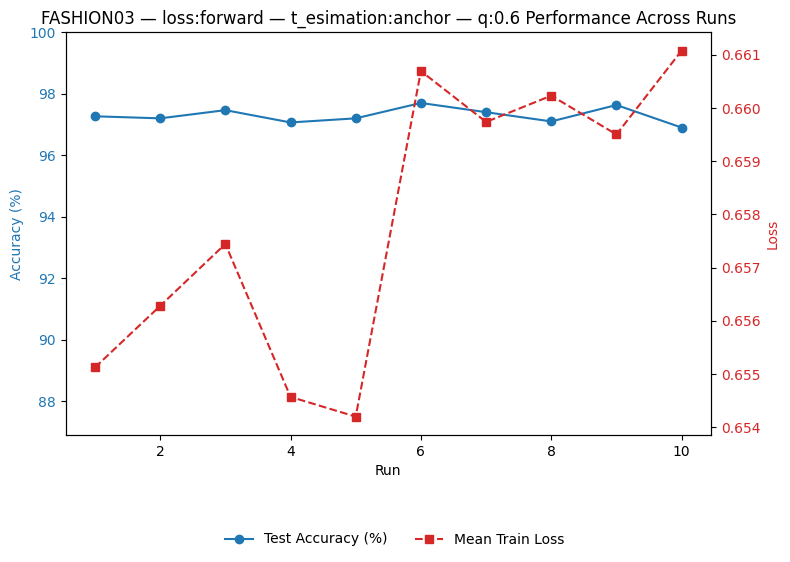

fashion03 | forward | mean±std acc: 97.29±0.24% | mean loss: 0.6579
T-error: Fro 0.6060, MAE 0.1652, RRE 0.4594
Appended results for forward → results_2025-11-06-18_19/fashion03_results.json

✅ Wrote table summary to results_2025-11-06-18_19\summary_results.tsv
| dataset   | loss    | estimate_T   |   epochs |   runs |   q |     lr |   beta |   mean_test_acc |   std_test_acc |   mean_train_loss |   std_train_loss |   fro_error |   mae_error |   rre_error |
|:----------|:--------|:-------------|---------:|-------:|----:|-------:|-------:|----------------:|---------------:|------------------:|-----------------:|------------:|------------:|------------:|
| fashion03 | forward | anchor       |       15 |     10 | 0.6 | 0.0001 | 0.0005 |           97.29 |           0.24 |            0.6579 |           0.0025 |       0.606 |      0.1652 |      0.4594 |


In [ ]:
results_rows = []
C = 3
graph_data = []
all_figs = []
os.mkdir(os.path.join(folder, 'img'))

# Debug mini test just do first 1 or few configs
# configs = configs[:1]

print(f"Total configs to run: {len(configs)}")

for cfg in configs:
    
    print("=" * 100)
    print(f"Running config {configs.index(cfg)+1}/{len(configs)}")
    print(json.dumps(cfg, indent=2))
    # collect summary rows for TSV
    dataset_file = f"{folder}/{cfg['dataset']}_results.json"
    if os.path.exists(dataset_file):
        with open(dataset_file, 'r') as f:
            try:
                all_data = json.load(f)
            except json.JSONDecodeError:
                all_data = []
    else:
        all_data = []


    all_acc = []
    all_mean_loss = []
    all_val_acc = []
    all_loss_arrays = []
    last_T = None
    t_arr = []
    
    # load data
    Xtr, Str, Xts, Yts = load_npz(DATA_PATHS[cfg['dataset']])
    # Transition matrix
    T = None
    train_loader, val_loader, is_cifar = make_loaders(Xtr, Str, batch_size=cfg['batch_size'], seed=0)
   
    if cfg['estimate_T']=='anchor':
        T = torch.zeros((C, C), dtype=torch.float32, device=device)
        T = estimate_transition_anchor(T, train_loader, is_cifar, q, device=device, epochs=cfg['est_epochs'])
        print("Estimated T:")
        print(np.array2string(T.cpu().numpy(), formatter={'float_kind':lambda x: f"{x:.4f}"}))
    else:
        T = pick_known_T(cfg['dataset'])
        print('known_T')
        print(T)
        if T is None:
            raise ValueError("Forward loss selected but no known T for this dataset; use --estimate_T.")
            
    #if isinstance(T, np.ndarray):
    #    T = torch.tensor(T, dtype=torch.float32, device=device)

    # get true T if known
    T_true = pick_known_T(cfg['dataset'])
    has_T_true = T_true is not None

    if T is not None:
        if not torch.is_tensor(T):
            T = torch.tensor(T, dtype=torch.float32, device=device)
        else:
            T = T.to(device=device, dtype=torch.float32)

        # Ensure row-stochastic
        T = torch.clamp(T, 1e-6, 1.0)
        T = T / T.sum(dim=1, keepdim=True)

        # Stabilize
        T = stabilize_T(T, alpha=0.5)

    train_loader, val_loader, is_cifar = make_loaders(Xtr, Str, batch_size=cfg['batch_size'], seed=0)

    for r in range(cfg['runs']):
        print(f">> Run:{r} Starting >>")
        acc, val_acc, T, loss_arr, grad_norms = run_once(cfg, T, seed=1000+r,   # seed only for weight init
                                                        train_loader=train_loader,
                                                        val_loader=val_loader)

        all_acc.append(acc)
        all_loss_arrays.append(loss_arr)
        all_mean_loss.append(np.mean(loss_arr))


        all_val_acc.append(val_acc)
        
        if cfg['loss'] == 't-revision':    # Only for TRevision
            t_arr.append(T.detach().cpu().numpy().tolist())

        last_T = T if T is not None else last_T

        print(f">> Run:{r} Finishing >>")

    graph_data.append({'cfg':cfg, 'all_acc':all_acc, 'all_mean_loss': all_mean_loss})
    fig = plot_run_performance(all_acc, all_mean_loss, cfg, folder)

    all_figs.append({
        "cfg": cfg,
        "figure": fig
    })
    
    mean_acc = float(np.mean(all_acc))
    std_acc  = float(np.std(all_acc))
    mean_loss = float(np.mean(all_mean_loss))
    std_loss  = float(np.std(all_mean_loss))

    # compute metrics vs true T (if available)
    fro_err = mae_err = rre_err = None
    if has_T_true and last_T is not None:
        T_true = np.array(T_true)
        T_est = last_T.detach().cpu().numpy().tolist()

        fro_err = float(np.linalg.norm(T_est - T_true, 'fro'))
        mae_err = float(np.mean(np.abs(T_est - T_true)))
        rre_err = float(fro_err / np.linalg.norm(T_true, 'fro'))

    # build summary object
    summary = {
        'cfg': cfg,
        'dataset': cfg['dataset'],
        'loss': cfg['loss'],
        'estimate_T': cfg['estimate_T'],
        'epochs': cfg['epochs'],
        'runs': cfg['runs'],
        'mean_test_acc': mean_acc,
        'std_test_acc': std_acc,
        'mean_train_loss': mean_loss,
        'std_train_loss': std_loss,
        'per_run_acc': all_acc,
        'per_run_mean_loss': all_mean_loss,
        'per_run_loss_arrays': all_loss_arrays,
    }
    if has_T_true:
        summary['true_T'] = T_true.tolist()
        summary['fro_error'] = fro_err
        summary['mae_error'] = mae_err
        summary['rre_error'] = rre_err
    
    if t_arr is not None:
        summary['t_arr'] = t_arr,


    all_data.append(summary)
    
    print(f"{cfg['dataset']} | {cfg['loss']} | mean±std acc: {mean_acc*100:.2f}±{std_acc*100:.2f}% | mean loss: {mean_loss:.4f}")
    print("=" * 100) 

    if fro_err is not None:
        print(f"T-error: Fro {fro_err:.4f}, MAE {mae_err:.4f}, RRE {rre_err:.4f}")

    with open(dataset_file, 'w') as f:
        json.dump(all_data, f, indent=2)
    print(f"Appended results for {cfg['loss']} → {dataset_file}")

    # ➕ Add a summary row for TSV
    results_rows.append({
        'dataset': cfg['dataset'],
        'loss': cfg['loss'],
        'estimate_T': cfg['estimate_T'],
        'epochs': cfg['epochs'],
        'runs': cfg['runs'],
        'q': cfg['q'],
        'lr': cfg['lr'],
        'beta': cfg['beta'],
        'mean_test_acc': round(mean_acc * 100, 2),
        'std_test_acc': round(std_acc * 100, 2),
        'mean_train_loss': round(mean_loss, 4),
        'std_train_loss': round(std_loss, 4),
        'fro_error': None if fro_err is None else round(fro_err, 4),
        'mae_error': None if mae_err is None else round(mae_err, 4),
        'rre_error': None if rre_err is None else round(rre_err, 4)
    })

# After each config loop, write TSV summary
if results_rows:
    df = pd.DataFrame(results_rows)
    tsv_path = os.path.join(folder, "summary_results.tsv")
    df.to_csv(tsv_path, sep='\t', index=False)
    print(f"\n✅ Wrote table summary to {tsv_path}")
    print(df.to_markdown(index=False))


## Evaluate

In [187]:
import os, json

for filename in os.listdir(folder):
    if filename.endswith(".json"):
        filepath = os.path.join(folder, filename)
        try:
            with open(filepath, "r", encoding="utf-8") as f:
                data = json.load(f)

            # handles both list of entries and single entry
            if isinstance(data, list):
                entries = data
            elif isinstance(data, dict):
                entries = [data]
            else:
                print(f"Unexpected format in {filename}: {type(data)}")
                continue

            for i, entry in enumerate(entries, start=1):
                dataset = entry.get("dataset", "N/A")
                loss = entry.get("loss", "N/A")
                mean_acc = entry.get("mean_test_acc", None)
                std_acc = entry.get("std_test_acc", None)

                print(f"{filename} [entry {i}]:")

                print(f" dataset       = {dataset}")
                print(f" loss          = {loss}")
                print(f" mean_test_acc = {mean_acc:.4f}" if mean_acc is not None else " mean_test_acc = N/A")
                print(f" std_test_acc  = {std_acc:.4f}" if std_acc is not None else " std_test_acc = N/A")
                print("-" * 60)

        except Exception as e:
            print(f"Error reading {filename}: {e}")


fashion03_results.json [entry 1]:
 dataset       = fashion03
 loss          = forward
 mean_test_acc = 0.9729
 std_test_acc  = 0.0024
------------------------------------------------------------


In [188]:
# for filename in os.listdir(folder):
#     if filename.endswith(".json"):
#         filepath = os.path.join(folder, filename)
#         try:
#             with open(filepath, "r", encoding="utf-8") as f:
#                 data = json.load(f)
            
#             dataset = data.get("dataset", "N/A")
#             loss = data.get("loss", "N/A")
#             mean_acc = data.get("mean_test_acc", None)
#             std_acc = data.get("std_test_acc", None)

#             print(f"{filename}:")
            
#             print(f"  dataset       = {dataset}")
#             print(f"  loss          = {loss}")
#             print(f"  mean_test_acc = {mean_acc:.4f}" if mean_acc is not None else "  mean_test_acc = N/A")
#             print(f"  std_test_acc  = {std_acc:.4f}" if std_acc is not None else "  std_test_acc = N/A")
#             print("-" * 60)

#         except Exception as e:
#             print(f"Error reading {filename}: {e}")

In [189]:
C = 3
files = os.listdir()
files = sorted(glob.glob('results*'), reverse=True)
folder = files[0]
print(folder)

# pattern for files starting with "name" and ending with ".json"
files = sorted(glob.glob(os.path.join(folder,"fashion03*.json")))
print(files)

# pick the first matching file
first_file = files[0]
print("Loading:", first_file)

# load the JSON contents
with open(first_file, "r", encoding="utf-8") as f:
    data = json.load(f)

T_prime = np.array(data['last_estimated_T'])
T_true = pick_known_T('fashion03')

#checking recreation performance
print(T_prime)
print(T_true)
print(f"Fro error: {np.linalg.norm(T_prime - T_true, 'fro')}")
print(f"rre error: {np.linalg.norm(T_prime - T_true, 'fro') / np.linalg.norm(T_true, 'fro')}")
print(f"mae error: {np.mean(np.abs(T_prime - T_true))}")


corrs = [st.pearsonr(T_true[i], T_prime[i])[0] for i in range(C)]
print("Per-row correlations:", corrs)
print("Mean:", np.mean(corrs))


# pattern for files starting with "name" and ending with ".json"
files = sorted(f for f in glob.glob(os.path.join(folder, "fashion06*.json")) if "None" not in f)


# pick the first matching file
first_file = files[0]
print("\nLoading:", first_file)
# load the JSON contents
with open(first_file, "r", encoding="utf-8") as f:
    data = json.load(f)
print()
T_prime = np.array(data['last_estimated_T'])

T_true = pick_known_T('fashion06')

#checking recreation performance
print(T_prime)
print(T_true)
print(f"Fro error: {np.linalg.norm(T_prime - T_true, 'fro')}")
print(f"rre error: {np.linalg.norm(T_prime - T_true, 'fro') / np.linalg.norm(T_true, 'fro')}")
print(f"mae error: {np.mean(np.abs(T_prime - T_true))}")


corrs = [st.pearsonr(T_true[i], T_prime[i])[0] for i in range(C)]
print("Per-row correlations:", corrs)
print("Mean:", np.mean(corrs))

results_2025-11-06-18_19
['results_2025-11-06-18_19\\fashion03_results.json']
Loading: results_2025-11-06-18_19\fashion03_results.json


TypeError: list indices must be integers or slices, not str

In [ ]:
import os
import glob
import json
import numpy as np
from scipy import stats as st

def evaluate_T_matrices(folder, pattern, dataset_name, C=3):
    """
    Loops over all JSON files matching pattern, computes error metrics 
    and correlations vs. known T, and returns best-performing result.
    """
    files = sorted(glob.glob(os.path.join(folder, pattern)))
    if not files:
        print(f"No files found matching: {pattern}")
        return None, None
    
    T_true = pick_known_T(dataset_name)
    results = []

    print(f"Evaluating {len(files)} files for dataset: {dataset_name}\n")

    for file in files:
        with open(file, "r", encoding="utf-8") as f:
            data = json.load(f)
        T_prime = np.array(data['last_estimated_T'])
        
        fro_err = np.linalg.norm(T_prime - T_true, 'fro')
        rre_err = fro_err / np.linalg.norm(T_true, 'fro')
        mae_err = np.mean(np.abs(T_prime - T_true))
        corrs = [st.pearsonr(T_true[i], T_prime[i])[0] for i in range(C)]
        mean_corr = np.mean(corrs)
        
        print(f"File: {os.path.basename(file)}")
        print(f"Fro error: {fro_err:.6f}")
        print(f"RRE error: {rre_err:.6f}")
        print(f"MAE error: {mae_err:.6f}")
        print(f"Per-row correlations: {np.round(corrs, 4)} | Mean: {mean_corr:.4f}")
        print("-" * 60)

        #checking recreation performance
        print("T_prime:")
        print(np.round(T_prime, 2))
        print("T_true:")
        print(np.round(T_true, 2))
        print("T_true - T_prime:")
        print(np.round(T_true - T_prime, 2))
        
        results.append({
            'file': file,
            'T_prime': T_prime,
            'fro': fro_err,
            'rre': rre_err,
            'mae': mae_err,
            'corr_mean': mean_corr
        })
    
    # Choose the best result (lowest Frobenius error)
    best = min(results, key=lambda x: x['fro'])
    print(f"\n✅ Best result: {os.path.basename(best['file'])}")
    print(f"   Fro error: {best['fro']:.6f}, RRE: {best['rre']:.6f}, MAE: {best['mae']:.6f}, Corr: {best['corr_mean']:.4f}")
    
    return best['file'], best['T_prime']


# Example usage

best_file_03, best_T_03 = evaluate_T_matrices(folder, "fashion03*.json", "fashion03", C=3)
best_file_06, best_T_06 = evaluate_T_matrices(folder, "fashion06*True*.json", "fashion06", C=3)
